In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score  
import cv2
import os
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset,concatenate_datasets
from evaluate import load
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)
import itertools 

In [2]:
model_checkpoint = "motheecreator/vit-Facial-Expression-Recognition" # pre-trained model from which to fine-tune


metric = load("accuracy")

In [3]:
fer_dataset = load_dataset("imagefolder", data_dir=r'C:\Users\hari\OneDrive\Documents\fer')

Resolving data files:   0%|          | 0/28716 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/7178 [00:00<?, ?it/s]

In [4]:
from datasets import DatasetDict, ClassLabel

# Assuming `dataset` is already defined

# Get the label names
label_names = fer_dataset['train'].features['label'].names

# Check if 'anger' exists in label_names before changing it
if 'anger' in label_names:
    # Change 'anger' to 'angry' in label names
    new_label_names = [name if name != 'anger' else 'angry' for name in label_names]

    # Update the label names in the dataset
    fer_dataset['train'] = fer_dataset['train'].rename_column('label', 'old_label')
    fer_dataset['train'] = fer_dataset['train'].rename_column('old_label', 'label')

    # Update the label 'anger' to 'angry' in the dataset
    fer_dataset['train'] = fer_dataset['train'].map(lambda example: {'label': 'angry' if example['label'] == 'anger' else example['label']})

    # Update the ClassLabel feature
    new_label_feature = ClassLabel(names=new_label_names)

    # Update the dataset's label feature
    fer_dataset['train'] = fer_dataset['train'].cast_column('label', new_label_feature)
    

In [5]:
fer_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 28716
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 7178
    })
})

In [6]:
labels = fer_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [7]:
label2id

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = image_processor.image_mean, image_processor.image_std

# Get the size (height) of the ViT model's input images
size = image_processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

# Define a set of transformations for training data
train_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        RandomRotation(90),               # Apply random rotation
        RandomAdjustSharpness(2),         # Adjust sharpness randomly
        RandomHorizontalFlip(0.5),        # Random horizontal flip
        ToTensor(),                       # Convert images to tensors
        normalize                          # Normalize images using mean and std
    ]
)
# Define a set of transformations for validation data
val_tf = Compose(
    [
        Resize((size, size)),             # Resize images to the ViT model's input size
        ToTensor(),                       # Convert images to tensors
        normalize                         # Normalize images using mean and std
    ]
)


Size:  224


In [10]:
# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples['pixel_values'] = [train_tf(image.convert("RGB")) for image in examples['image']]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples['pixel_values'] = [val_tf(image.convert("RGB")) for image in examples['image']]
    return examples

In [11]:
train_dataset = fer_dataset['train']
test_dataset = fer_dataset['test']
train_dataset.set_transform(train_transforms)
test_dataset.set_transform(val_transforms)


In [12]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=48x48>,
 'label': 0,
 'pixel_values': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -

In [13]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

In [14]:
notebook_login()

In [15]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}",
    remove_unused_columns=False,
    evaluation_strategy="steps",
    save_strategy="steps",  # Align with evaluation_strategy
    learning_rate=3e-5,
    lr_scheduler_type="cosine",
    auto_find_batch_size=True,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_steps=1000,
    logging_steps=50,
    eval_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    
    report_to="none"
)

C:\Users\hari\anaconda3\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [17]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [18]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

C:\Users\hari\AppData\Local\Temp\ipykernel_41340\1634715992.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
train_results = trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.531500,0.257707,0.911814
200,0.540300,0.257075,0.913207
300,0.510900,0.257791,0.909446
400,0.519800,0.268763,0.909724
500,0.483600,0.273787,0.905545
600,0.495500,0.290500,0.900808


Could not locate the best model at vit-Facial-Expression-Recognition\checkpoint-200\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


In [4]:
torch.save(model, 'entire_modelv2.pth')
torch.save(model.state_dict(), 'model_weightsv2.pth')

NameError: name 'torch' is not defined

In [20]:
trainer.evaluate()

{'eval_loss': 0.2848995327949524,
 'eval_accuracy': 0.9069378657007523,
 'eval_runtime': 961.4348,
 'eval_samples_per_second': 7.466,
 'eval_steps_per_second': 0.234,
 'epoch': 2.9888641425389757}

In [21]:
# Assuming `trainer` is your Hugging Face Trainer and `test_dataset` is defined
eval_results = trainer.predict(test_dataset)
predictions = np.argmax(eval_results.predictions, axis=1)
labels = eval_results.label_ids


Classification Report:

              precision    recall  f1-score   support

       angry       0.90      0.86      0.88       958
     disgust       0.95      0.92      0.94       111
        fear       0.87      0.83      0.85      1024
       happy       0.96      0.97      0.96      1774
     neutral       0.88      0.92      0.90      1233
         sad       0.88      0.88      0.88      1247
    surprise       0.93      0.94      0.94       831

    accuracy                           0.91      7178
   macro avg       0.91      0.90      0.91      7178
weighted avg       0.91      0.91      0.91      7178



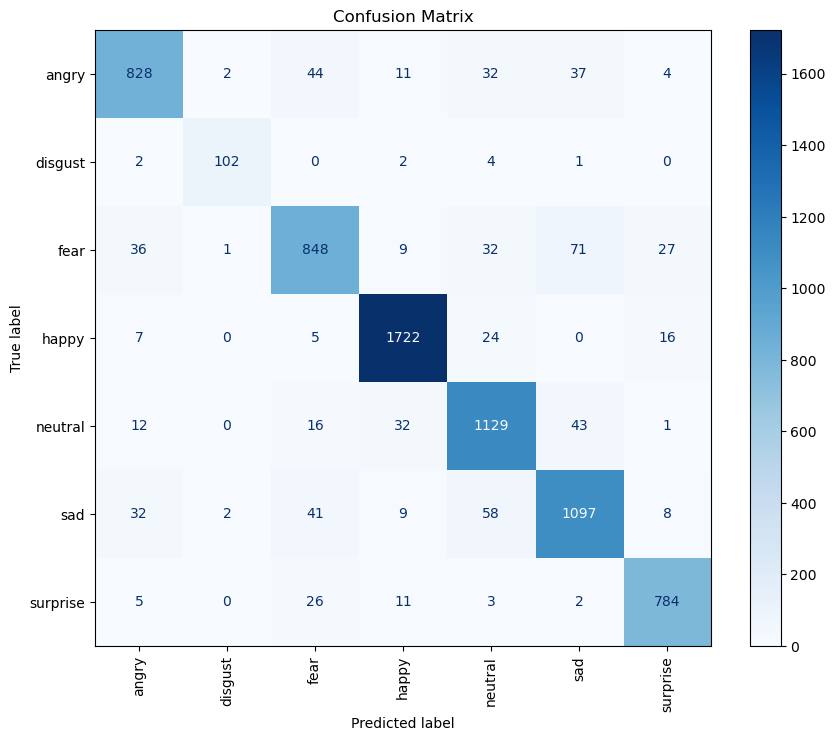

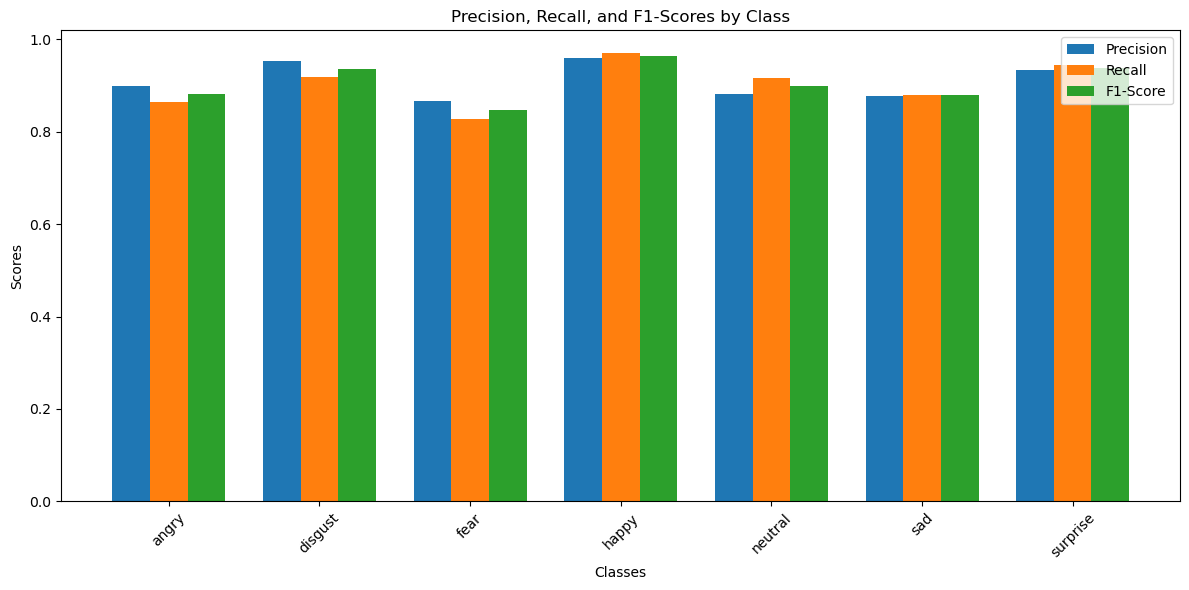

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `predictions` and `labels` are numpy arrays
# Replace `eval_pred.predictions` and `eval_pred.label_ids` with your actual predictions and labels


# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Compute precision, recall, F1-score for each class
class_report = classification_report(labels, predictions, target_names=id2label.values(), output_dict=True)
precision = [class_report[label]['precision'] for label in id2label.values()]
recall = [class_report[label]['recall'] for label in id2label.values()]
f1_scores = [class_report[label]['f1-score'] for label in id2label.values()]

# Print the classification report
print("Classification Report:\n")
print(classification_report(labels, predictions, target_names=id2label.values()))

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=id2label.values())
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# Bar Graph for Precision, Recall, and F1-Scores
x_labels = id2label.values()
x = np.arange(len(x_labels))  # Label locations

plt.figure(figsize=(12, 6))
width = 0.25  # Bar width

# Bar plots
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_scores, width, label='F1-Score')

# Add labels and legend
plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Precision, Recall, and F1-Scores by Class")
plt.xticks(ticks=x, labels=x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


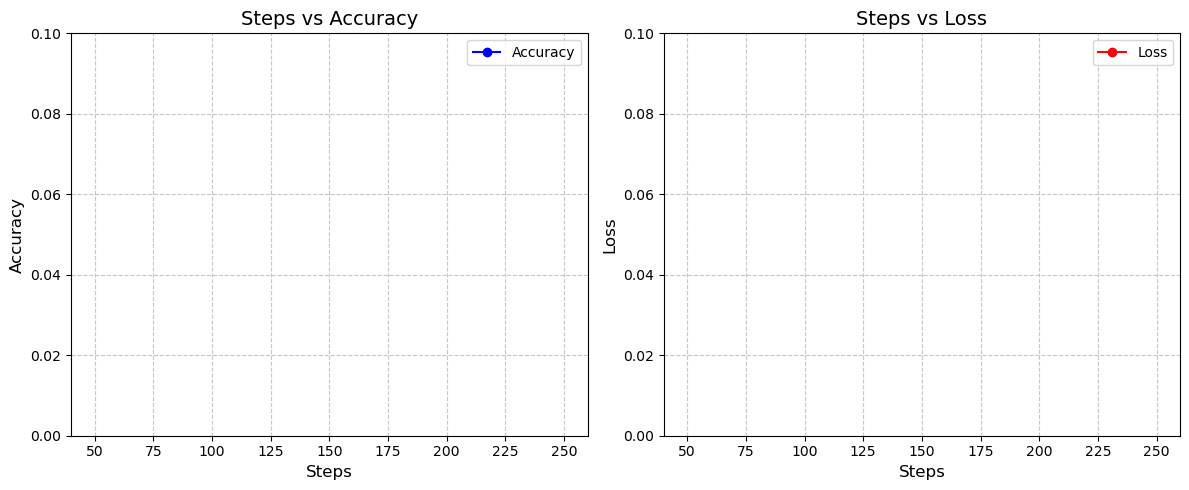

In [24]:
import matplotlib.pyplot as plt

# Train the model
trainer.train()

# Extract losses and accuracies
train_losses, eval_losses = [], []
train_acc, eval_acc = [], []
steps = []

for log in trainer.state.log_history:
    if "loss" in log:
        train_losses.append(log["loss"])
        steps.append(log["step"])
    if "eval_loss" in log:
        eval_losses.append(log["eval_loss"])
    if "accuracy" in log:
        eval_acc.append(log["accuracy"])
    if "train_accuracy" in log:  # If available
        train_acc.append(log["train_accuracy"])

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(train_losses)], train_losses, label="Training Loss", marker="o")
plt.plot(steps[:len(eval_losses)], eval_losses, label="Validation Loss", marker="s")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(steps[:len(train_acc)], train_acc, label="Training Accuracy", marker="o", color="blue")
plt.plot(steps[:len(eval_acc)], eval_acc, label="Validation Accuracy", marker="s", color="green")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Curve")
plt.legend()
plt.grid()
plt.show()


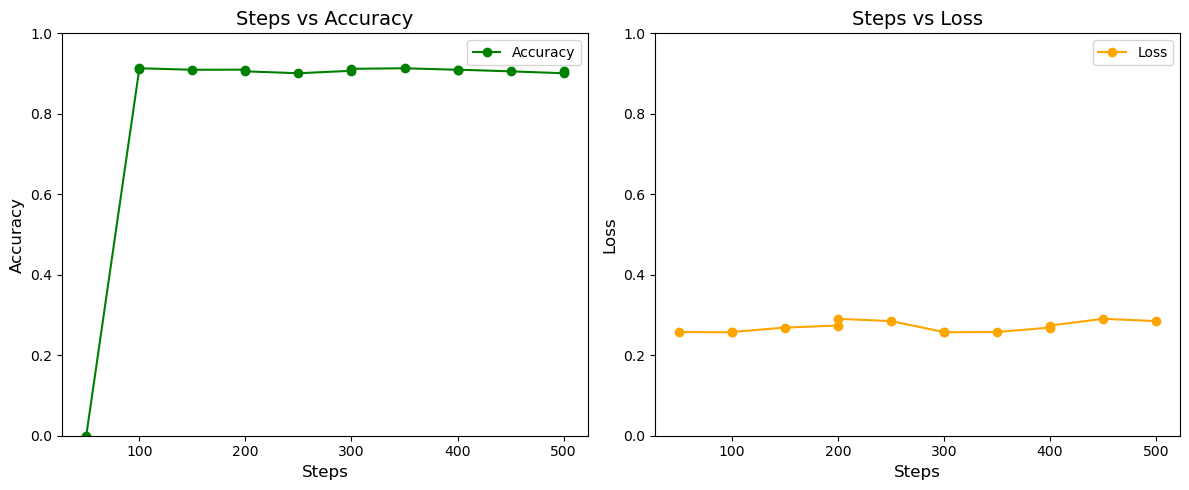

In [55]:
import matplotlib.pyplot as plt

# Extract training logs from trainer's state
log_history = trainer.state.log_history

# Initialize lists to store steps, accuracy, and loss
steps = []
accuracy = [0, 0.9118138757314015, 0.9132070214544441, 0.909445528002229, 0.9097241571468375, 0.9055447199777097, 0.9008080245193647, 0.9069378657007523]
loss = [0.25770658254623413, 0.25707486271858215, 0.25779080390930176, 0.2687630355358124, 0.2737870514392853, 0.2904999256134033, 0.2848995327949524]

# Iterate through the log history to populate the lists
for log in log_history:
    if 'step' in log:
        steps.append(log['step'])
    if 'eval_accuracy' in log:  # Replace with the exact accuracy key, if different
        accuracy.append(log['eval_accuracy'])
    if 'eval_loss' in log:  # Replace with the exact loss key, if different
        loss.append(log['eval_loss'])

# Plot Steps vs Accuracy and Steps vs Loss
plt.figure(figsize=(12, 5))

# Subplot 1: Steps vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(steps[:len(accuracy)], accuracy, marker='o', color='green', label='Accuracy')
plt.title('Steps vs Accuracy', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0,1.0])

plt.legend()

# Subplot 2: Steps vs Loss
plt.subplot(1, 2, 2)
plt.plot(steps[:len(loss)], loss, marker='o', color='orange', label='Loss')
plt.title('Steps vs Loss', fontsize=14)
plt.xlabel('Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim([0,1.0])

plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()

In [27]:
print("Steps:", steps)
print("Accuracy:", accuracy)
print("Loss:", loss)


Steps: [0, 50, 100, 100, 150, 200, 200, 250]
Accuracy: [0, 0.9118138757314015, 0.9132070214544441, 0.909445528002229, 0.9097241571468375, 0.9055447199777097, 0.9008080245193647, 0.9069378657007523]
Loss: [0, 0.25770658254623413, 0.25707486271858215, 0.25779080390930176, 0.2687630355358124, 0.2737870514392853, 0.2904999256134033, 0.2848995327949524]


In [48]:
from sklearn.metrics import cohen_kappa_score
class_report = classification_report(labels, predictions, target_names=id2label.values(), output_dict=True)
kappa_score = cohen_kappa_score(labels, predictions)
print(f"\nCohen's Kappa Score: {kappa_score:.4f}")


Cohen's Kappa Score: 0.8874



Overall Cohen's Kappa Score: 0.8874

Cohen's Kappa Score Per Class:
Angry: 0.8629
Disgust: 0.9348
Fear: 0.8214
Happy: 0.9530
Neutral: 0.8761
Sad: 0.8527
Surprise: 0.9302


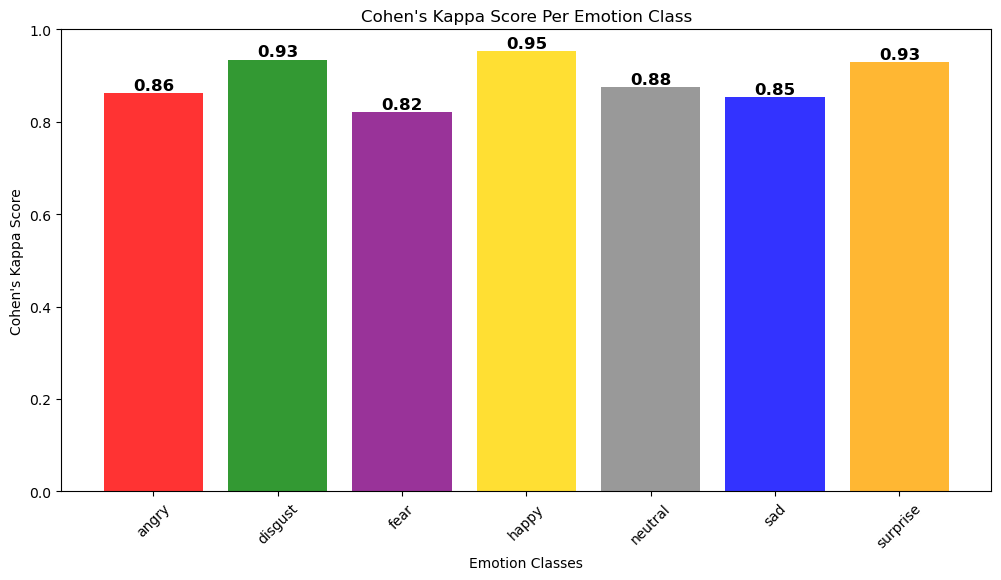

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import label_binarize

# Compute Cohen's Kappa score for overall classification
kappa_score = cohen_kappa_score(labels, predictions)
print(f"\nOverall Cohen's Kappa Score: {kappa_score:.4f}")

# Emotion classes
classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]
num_classes = len(classes)

# Assign colors based on emotions
emotion_colors = {
    "angry": "#FF0000",     # Red
    "disgust": "#008000",   # Green
    "fear": "#800080",      # Dark Purple
    "happy": "#FFD700",     # Yellow
    "neutral": "#808080",   # Gray
    "sad": "#0000FF",       # Blue
    "surprise": "#FFA500"   # Orange
}

# Binarize labels and predictions
labels_bin = label_binarize(labels, classes=range(num_classes))
predictions_bin = label_binarize(predictions, classes=range(num_classes))

# Compute Cohen's Kappa for each class
kappa_scores_per_class = [
    cohen_kappa_score(labels_bin[:, i], predictions_bin[:, i]) for i in range(num_classes)
]

# Print Cohen's Kappa for each class
print("\nCohen's Kappa Score Per Class:")
for cls, score in zip(classes, kappa_scores_per_class):
    print(f"{cls.capitalize()}: {score:.4f}")

# Plot Cohen's Kappa per class with corresponding colors
plt.figure(figsize=(12, 6))
bars = plt.bar(classes, kappa_scores_per_class, color=[emotion_colors[cls] for cls in classes], alpha=0.8)

# Add value labels on top of bars
for bar, score in zip(bars, kappa_scores_per_class):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{score:.2f}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel("Emotion Classes")
plt.ylabel("Cohen's Kappa Score")
plt.title("Cohen's Kappa Score Per Emotion Class")
plt.ylim(0, 1)  # Cohen's Kappa ranges from -1 to 1, but usually between 0 and 1
plt.xticks(rotation=45)


# Show the plot
plt.show()


Classification Report:

              precision    recall  f1-score   support

       angry       0.90      0.86      0.88       958
     disgust       0.95      0.92      0.94       111
        fear       0.87      0.83      0.85      1024
       happy       0.96      0.97      0.96      1774
     neutral       0.88      0.92      0.90      1233
         sad       0.88      0.88      0.88      1247
    surprise       0.93      0.94      0.94       831

    accuracy                           0.91      7178
   macro avg       0.91      0.90      0.91      7178
weighted avg       0.91      0.91      0.91      7178



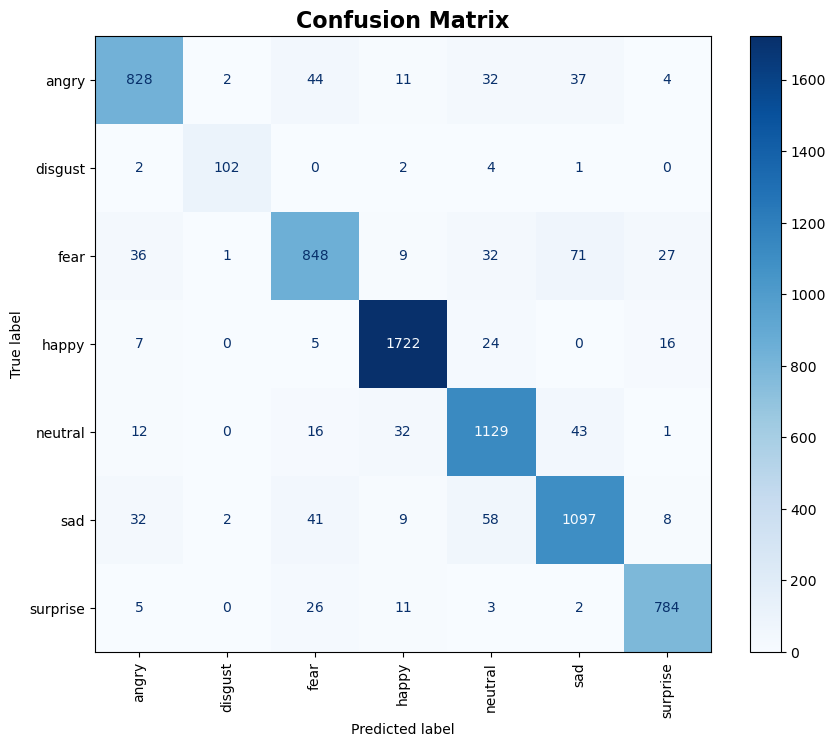

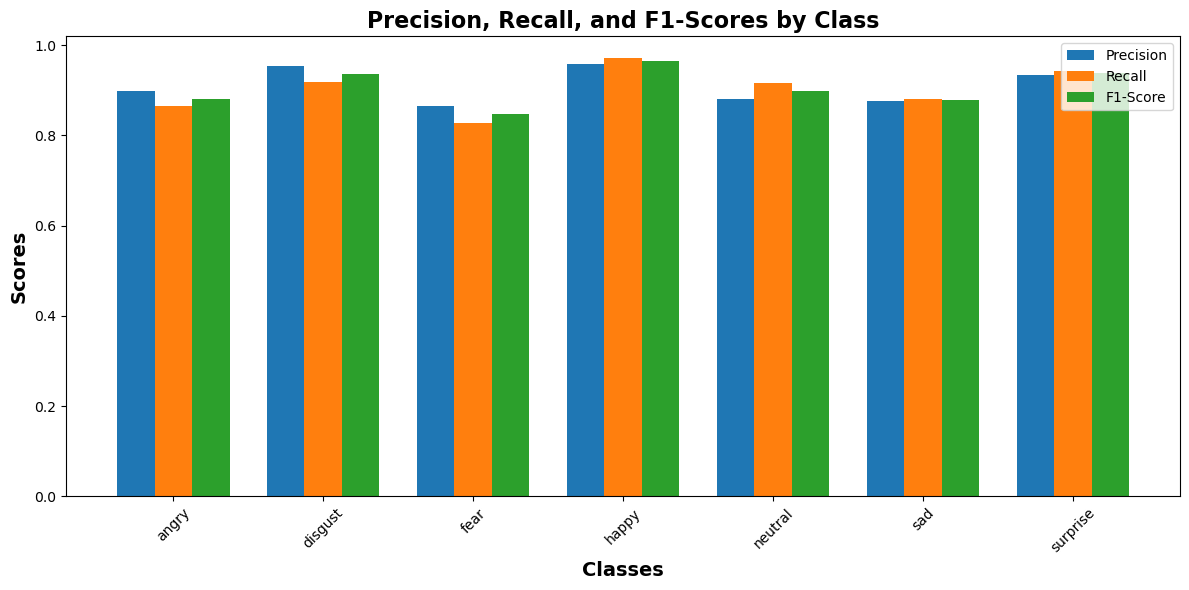

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming `predictions` and `labels` are numpy arrays
# Replace `eval_pred.predictions` and `eval_pred.label_ids` with your actual predictions and labels

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Compute precision, recall, F1-score for each class
class_report = classification_report(labels, predictions, target_names=id2label.values(), output_dict=True)
precision = [class_report[label]['precision'] for label in id2label.values()]
recall = [class_report[label]['recall'] for label in id2label.values()]
f1_scores = [class_report[label]['f1-score'] for label in id2label.values()]

# Print the classification report
print("Classification Report:\n")
print(classification_report(labels, predictions, target_names=id2label.values()))

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=id2label.values())
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')  # Bold title
plt.show()

# Bar Graph for Precision, Recall, and F1-Scores
x_labels = list(id2label.values())  # Convert to list for indexing
x = np.arange(len(x_labels))  # Label locations

plt.figure(figsize=(12, 6))
width = 0.25  # Bar width

# Create bars
bars1 = plt.bar(x - width, precision, width, label='Precision')
bars2 = plt.bar(x, recall, width, label='Recall')
bars3 = plt.bar(x + width, f1_scores, width, label='F1-Score')

# Add value labels (bold)


# Add bold labels and legend
plt.xlabel("Classes", fontsize=14, fontweight='bold')  # Bold x-axis label
plt.ylabel("Scores", fontsize=14, fontweight='bold')   # Bold y-axis label
plt.title("Precision, Recall, and F1-Scores by Class", fontsize=16, fontweight='bold')  # Bold title
plt.xticks(ticks=x, labels=x_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


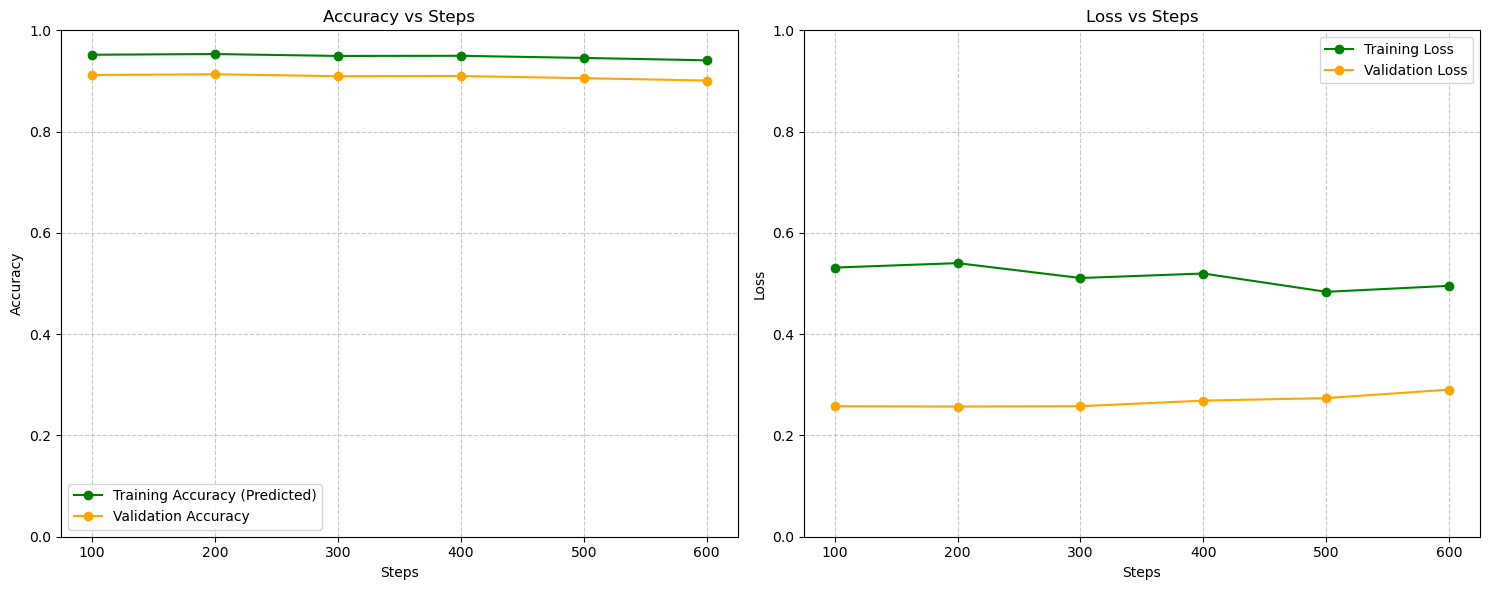

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Data
steps = [100, 200, 300, 400, 500, 600]

# Loss values (original, unscaled)
training_loss = [0.531500, 0.540300, 0.510900, 0.519800, 0.483600, 0.495500]
validation_loss = [0.257707, 0.257075, 0.257791, 0.268763, 0.273787, 0.290500]

# Accuracy values 
validation_accuracy = [0.911814, 0.913207, 0.909446, 0.909724, 0.905545, 0.900808]
predicted_training_accuracy = [0.9518, 0.9532, 0.9494, 0.9497, 0.9455, 0.9408]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Accuracy vs Steps - green for training, orange for validation
ax1.plot(steps, predicted_training_accuracy, 'g-o', label='Training Accuracy (Predicted)')
ax1.plot(steps, validation_accuracy, 'orange', marker='o', linestyle='-', label='Validation Accuracy')
ax1.set_title('Accuracy vs Steps')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Accuracy')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()
ax1.set_ylim(0, 1.0)  # Set y-axis from 0 to 1

# Plot 2: Loss vs Steps - green for training, orange for validation
ax2.plot(steps, training_loss, 'g-o', label='Training Loss')
ax2.plot(steps, validation_loss, 'orange', marker='o', linestyle='-', label='Validation Loss')
ax2.set_title('Loss vs Steps')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()
ax2.set_ylim(0, 1.0)  # Set y-axis from 0 to 1

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)
plt.show()